## Kinda live dashboard :)

In [38]:
# Imports and configuration
import json
import time
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

pd.options.mode.chained_assignment = None

DATA_FILES = {
    'HTTP': Path('http_recorded_data.csv'),
    'MQTT': Path('mqtt_recorded_data.csv')
}

Y_LIMITS = {
    'humidity': (0, 100),
    'temperature': (0, 100),
    'light': (0, 40000)
}

REFRESH_SECONDS = 5
MAX_POINTS_PER_DEVICE = 20


def load_config(path='config.json'):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"{path} not found")
    with p.open('r', encoding='utf-8') as f:
        return json.load(f)

In [39]:
def csv_for_protocol(protocol: str) -> Path:
    if protocol and protocol.upper() == 'MQTT':
        return DATA_FILES['MQTT']
    return DATA_FILES['HTTP']


def load_df(csv_path: Path) -> pd.DataFrame | None:
    """Load the CSV and normalize columns. Returns None if file missing."""
    if not csv_path.exists():
        return None
    # The recorded CSVs use a header; read normally
    df = pd.read_csv(csv_path)
    expected_cols = ['device_id', 'time', 'date', 'protocol', 'sensor_type', 'value']
    # If the file lacks header for any reason, try to set names
    if list(df.columns)[:6] != expected_cols:
        # attempt to coerce first 6 columns
        df = pd.read_csv(csv_path, header=None)
        if df.shape[1] >= 6:
            df = df.iloc[:, :6]
            df.columns = expected_cols
        else:
            raise ValueError('CSV format not recognized')

    # Create datetime column combining date + time (handle parsing errors)
    df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str), errors='coerce')
    # normalize sensor type to lowercase
    df['sensor_type'] = df['sensor_type'].astype(str).str.lower()
    # numeric values
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    # drop rows without datetime
    df = df.dropna(subset=['datetime'])
    return df


def derive_device_list(df: pd.DataFrame, protocol: str, cfg: dict) -> list:
    """Return a list of device ids to plot, respecting config num_devices if possible."""
    all_devices = sorted(df['device_id'].unique())
    key = 'num_devices_mqtt' if protocol.upper() == 'MQTT' else 'num_devices_http'
    try:
        n = int(cfg.get(key, 0)) if cfg.get(key) is not None else 0
    except Exception:
        n = 0
    if n and n > 0:
        # construct expected device ids and keep those present in the CSV
        chosen = []
        for i in range(1, n + 1):
            did = 'id_device' if i == 1 else f'id_device{i}'
            if did in all_devices:
                chosen.append(did)
        # fallback to all devices if none of the expected ids found
        return chosen if chosen else all_devices
    return all_devices

In [40]:
def plot_sensors(df: pd.DataFrame, devices: list, max_points=20):
    cmap = plt.get_cmap('tab20')
    colors = cmap.colors if hasattr(cmap, 'colors') else None

    sensors = [
        ('light', Y_LIMITS['light']),
        ('humidity', Y_LIMITS['humidity']),
        ('temperature', Y_LIMITS['temperature'])
    ]

    for sensor, ylim in sensors:
        plt.figure(figsize=(12, 4))
        plotted_any = False
        for idx, device in enumerate(devices):
            ddf = df[(df['device_id'] == device) & (df['sensor_type'] == sensor)]
            if ddf.empty:
                continue
            ddf = ddf.sort_values('datetime').tail(max_points)
            # protect against NaN values
            if ddf['value'].dropna().empty:
                continue
            color = None
            if colors:
                color = colors[idx % len(colors)]
            plt.plot(ddf['datetime'], ddf['value'], marker='o', label=device, color=color)
            plotted_any = True
        plt.title(f'{sensor.capitalize()} — latest {max_points} points per device')
        plt.xlabel('Time')
        plt.ylabel(sensor.capitalize())
        plt.ylim(ylim)
        if plotted_any:
            plt.legend(loc='best')
        else:
            plt.text(0.5, 0.5, 'No data for this sensor', ha='center', va='center')
        plt.tight_layout()
        plt.show()


def live_dashboard(refresh_seconds=REFRESH_SECONDS, max_points=MAX_POINTS_PER_DEVICE):
    cfg = load_config()
    protocol = cfg.get('protocol', 'HTTP')
    csv_path = csv_for_protocol(protocol)
    print(f'Protocol: {protocol} — reading from: {csv_path}')
    print('Press Interrupt (Kernel -> Interrupt / Stop) to end live updates')
    while True:
        clear_output(wait=True)
        print(f'Protocol: {protocol} — reading from: {csv_path}')
        df = load_df(csv_path)
        if df is None or df.empty:
            print(f'No data found in {csv_path}. Retrying in {refresh_seconds}s...')
            try:
                time.sleep(refresh_seconds)
                continue
            except KeyboardInterrupt:
                print('Stopped by user')
                break

        devices = derive_device_list(df, protocol, cfg)
        if not devices:
            print('No device IDs found in CSV; retrying...')
            time.sleep(refresh_seconds)
            continue

        # Plot each sensor
        plot_sensors(df, devices, max_points=max_points)
        print(f'Updated: {pd.Timestamp.now()} — refreshing in {refresh_seconds}s')
        try:
            time.sleep(refresh_seconds)
        except KeyboardInterrupt:
            print('Stopped by user')
            break

# Live device time-series dashboard

This notebook reads `config.json` to determine the active protocol (HTTP or MQTT), then reads the corresponding recorded CSV (`http_recorded_data.csv` or `mqtt_recorded_data.csv`) and draws three time-series plots: `light`, `humidity`, and `temperature`.

Behavior:
- For the selected protocol the notebook will plot data for each device present in the CSV (limited to the `num_devices_http` / `num_devices_mqtt` value from `config.json` when possible).
- Each plot shows up to the latest 20 points per device for that sensor type.
- The notebook refreshes the plots every 5 seconds so you can run `run_demo.py` in the background and watch a lightweight live dashboard.

Usage:
1. Start your simulation (e.g. `python run_demo.py`) in a terminal.
2. Run the code cells below. The plotting cell will keep updating until you stop it (Interrupt the cell to stop). Hit execute all cells for live results

Protocol: MQTT — reading from: mqtt_recorded_data.csv


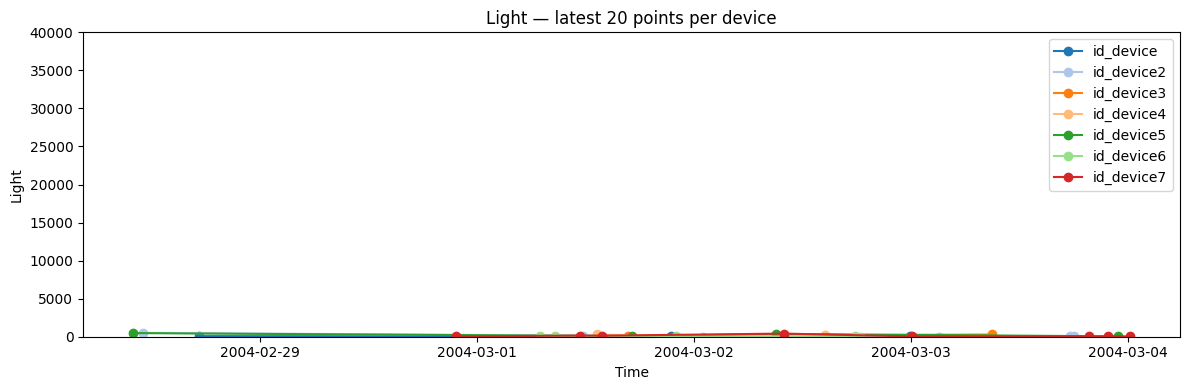

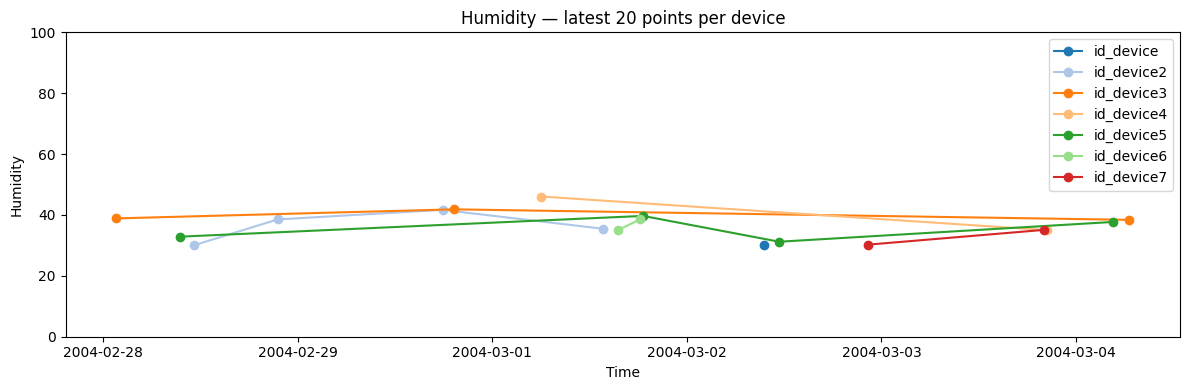

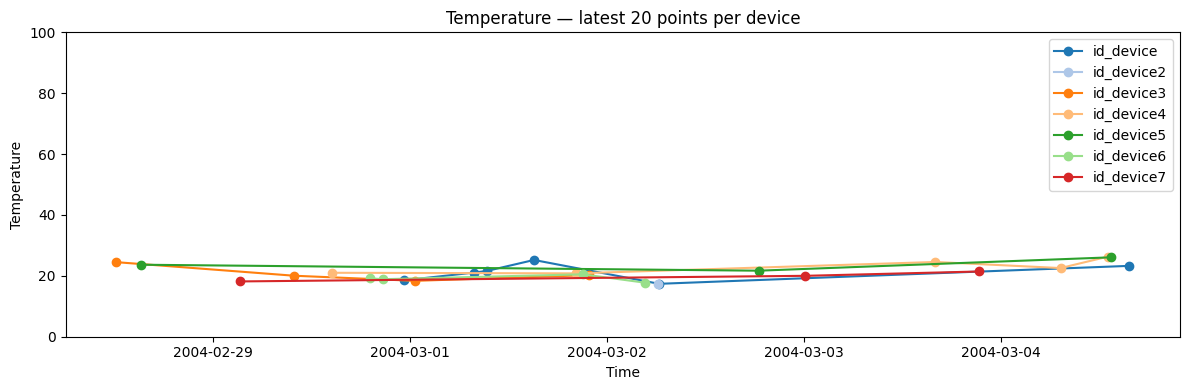

Updated: 2025-10-22 22:12:14.689824 — refreshing in 5s
Stopped by user
Stopped by user


In [41]:
live_dashboard()